In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Remove original columns that have been ordinalized

In [3]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Dummify Nominal Features

In [4]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold']

In [5]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Perform Train / Test Split

In [6]:
X = df.drop(['SalePrice', 'PID'], axis = 1)
y = df['SalePrice']

In [7]:
# Split the data into train and test based on the year the house was sold
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)].drop(['SalePrice', 'PID'], axis = 1)
X_test = df.loc[df['YrSold'].astype(int) == 2010].drop(['SalePrice', 'PID'], axis = 1)

y_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)]['SalePrice']
y_test = df.loc[df['YrSold'].astype(int) == 2010]['SalePrice']

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [9]:
model_baseline = GradientBoostingRegressor(random_state=42)

In [10]:
model_baseline.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [11]:
# evaluate untuned / baseline model
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# R2
r2_baseline_train = model_baseline.score(X_train, y_train)
r2_baseline_test = model_baseline.score(X_test, y_test)

print(f"Train R square: {r2_baseline_train:.4f}")
print(f"Test R square: {r2_baseline_test:.4f}")

# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Root Mean Squared Error: {rmse_baseline_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_baseline_test:.2f}")

Train R square: 0.9705
Test R square: 0.9198
Train Root Mean Squared Error: 12980.61
Test Root Mean Squared Error: 21043.55


In [12]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize baseline model
model = GradientBoostingRegressor(random_state=42)

# Lists to store the scores and RMSE values
scores = []
rmse_values = []

# Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.9064
Average baseline RMSE: $22766.66
Standard deviation of RMSE: $4545.07


## Hyperparameter Tuning

In [13]:
# param_grid = {
#     'loss':['huber'], # dataset has outlier so use huber might be better
#     'alpha':[0.85, 0.95], # alpha = 0.95 means top 5% largest residuals are treated linearly, only matter if loss is huber
#     'n_estimators': range(100, 200, 50),
#     'learning_rate': [0.03, 0.05, 0.1],
#     'max_depth': [3, 4],
# #     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [20, 30, 40],
#     'subsample':[0.7, 0.8, 0.9],
#     'max_features': [0.5]
# }

In [14]:
# gbr = GradientBoostingRegressor()

# # if done repeated CV in this step sometimes it takes a bit too long for 0.01% increase in R square test score
# # --- repeated CV: 5 folds, 5 repeats ---
# #rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# grid_search_gbr = GridSearchCV(estimator=gbr,
#                            param_grid=param_grid,
#                            cv=5,
#                            #cv=rkf,
#                            n_jobs=-1,
#                            verbose=0,
#                            scoring='r2')

# grid_search_gbr.fit(x_train, y_train)
# %time grid_search_gbr.fit(x_train, y_train)

In [15]:
# print("Best Parameters:", grid_search_gbr.best_params_)
# print("Best Score R square:", grid_search_gbr.best_score_)

In [16]:
import optuna
from optuna.samplers import TPESampler

In [17]:
# It's a good practice to set up logging to see Optuna's progress
optuna.logging.set_verbosity(optuna.logging.INFO)

#X_tra, X_val, y_tra, y_val
def objective(trial):
    """
    This function defines the search space for Optuna. It suggests hyperparameters,
    trains the model on the training set, evaluates it on the validation set, and returns
    a single value to be optimized (R-squared score).

    Args:
        trial (optuna.trial.Trial): The trial object that suggests hyperparameters.

    Returns:
        float: The R-squared score on the validation set.
    """
    # Define the search space for the hyperparameters using trial.suggest_...
    param = {

        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 50),
        
        'validation_fraction': trial.suggest_float('validation_fraction', 0.1, 0.5),
    
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
        
    }

    # The 'alpha' parameter is only relevant for the 'huber' loss function
    if param['loss'] == 'huber':
        param['alpha'] = trial.suggest_float('alpha', 0.1, 0.9)
                                          
    # Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)
    n_splits = 5
    n_repeats = 3
    rkf = RepeatedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=42) 
    
    r2_scores = []
    
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]    

    
    # Initialize the GradientBoosting Regressor with the parameters suggested by the trial
    model = GradientBoostingRegressor(**param, random_state = 42)

    # Train the model on the training data.
    # We use the test set as the evaluation set to allow for early stopping,
    # which can prevent overfitting and save time.
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation data
    y_pred = model.predict(X_val_fold)
    
    # Calculate the R-squared score on the validation set
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

    # Optuna needs a single value to optimize, so we return the R-squared score
    return np.mean(r2_scores)

In [18]:
# --- Create the Optuna study and run the optimization ---
# We want to maximize the R-squared score, so we set direction='maximize'
# We explicitly use TPESampler as requested.
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

print("Starting Optuna optimization for hyperparameter tuning...")
# Run the optimization for a specified number of trials.
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Print the results ---
print("-" * 30)
print("Optuna optimization completed.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best R-squared score found: {study.best_value:.4f}")
print("\nBest parameters found:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-09-12 16:12:09,592] A new study created in memory with name: no-name-7963f00c-6338-4728-b081-96c309746335


Starting Optuna optimization for hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:09,820] Trial 0 finished with value: 0.8404577867891797 and parameters: {'n_estimators': 437, 'learning_rate': 0.3984727409321965, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.5779972601681014, 'n_iter_no_change': 7, 'validation_fraction': 0.4464704583099741, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.8404577867891797.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:10,418] Trial 1 finished with value: 0.9057238381516292 and parameters: {'n_estimators': 973, 'learning_rate': 0.2311294500510414, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.6521211214797689, 'n_iter_no_change': 29, 'validation_fraction': 0.2727780074568463, 'loss': 'absolute_error'}. Best is trial 1 with value: 0.9057238381516292.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:15,041] Trial 2 finished with value: 0.9248207689818678 and parameters: {'n_estimators': 363, 'learning_rate': 0.02702051927323664, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.7571172192068059, 'n_iter_no_change': 32, 'validation_fraction': 0.1185801650879991, 'loss': 'squared_error'}. Best is trial 2 with value: 0.9248207689818678.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:23,384] Trial 3 finished with value: 0.8587866831208857 and parameters: {'n_estimators': 954, 'learning_rate': 0.42680949314334127, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.8421165132560784, 'n_iter_no_change': 25, 'validation_fraction': 0.14881529393791154, 'loss': 'huber', 'alpha': 0.3070239852800135}. Best is trial 2 with value: 0.9248207689818678.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:28,316] Trial 4 finished with value: 0.8945101495665185 and parameters: {'n_estimators': 696, 'learning_rate': 0.02100836027186265, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.9847923138822793, 'n_iter_no_change': 40, 'validation_fraction': 0.4757995766256756, 'loss': 'huber', 'alpha': 0.1707940016415356}. Best is trial 2 with value: 0.9248207689818678.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:32,712] Trial 5 finished with value: 0.7785491408585834 and parameters: {'n_estimators': 276, 'learning_rate': 0.00615778586183301, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647, 'n_iter_no_change': 21, 'validation_fraction': 0.2123738038749523, 'loss': 'huber', 'alpha': 0.15964051494381667}. Best is trial 2 with value: 0.9248207689818678.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:34,774] Trial 6 finished with value: 0.9163152189448436 and parameters: {'n_estimators': 989, 'learning_rate': 0.17516992455793434, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8534286719238086, 'n_iter_no_change': 38, 'validation_fraction': 0.4085081386743783, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.9248207689818678.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:36,121] Trial 7 finished with value: 0.9312753328019462 and parameters: {'n_estimators': 877, 'learning_rate': 0.08821983841690773, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6625916610133735, 'n_iter_no_change': 38, 'validation_fraction': 0.35502298854208525, 'loss': 'squared_error'}. Best is trial 7 with value: 0.9312753328019462.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:39,730] Trial 8 finished with value: 0.9204751598239606 and parameters: {'n_estimators': 742, 'learning_rate': 0.16616521031133955, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 5, 'subsample': 0.7613664146909971, 'n_iter_no_change': 24, 'validation_fraction': 0.11016765069763808, 'loss': 'huber', 'alpha': 0.3514847848610614}. Best is trial 7 with value: 0.9312753328019462.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:39,971] Trial 9 finished with value: 0.900065869416891 and parameters: {'n_estimators': 558, 'learning_rate': 0.32666526101138676, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.6143990827458112, 'n_iter_no_change': 8, 'validation_fraction': 0.21590058116550723, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.9312753328019462.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:40,412] Trial 10 finished with value: 0.9242677171144892 and parameters: {'n_estimators': 162, 'learning_rate': 0.0714988980654497, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.5193625999805915, 'n_iter_no_change': 49, 'validation_fraction': 0.3551887020844243, 'loss': 'squared_error'}. Best is trial 7 with value: 0.9312753328019462.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:42,269] Trial 11 finished with value: 0.9310385573933604 and parameters: {'n_estimators': 381, 'learning_rate': 0.040520150216653464, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 4, 'subsample': 0.7098683357772, 'n_iter_no_change': 35, 'validation_fraction': 0.32931639106049165, 'loss': 'squared_error'}. Best is trial 7 with value: 0.9312753328019462.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:44,518] Trial 12 finished with value: 0.934654455696081 and parameters: {'n_estimators': 577, 'learning_rate': 0.06659323716689775, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 5, 'subsample': 0.6887471426927588, 'n_iter_no_change': 44, 'validation_fraction': 0.32225830049475895, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:48,502] Trial 13 finished with value: 0.9200651459859823 and parameters: {'n_estimators': 769, 'learning_rate': 0.07928154283702982, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 7, 'subsample': 0.6839849868999038, 'n_iter_no_change': 48, 'validation_fraction': 0.3752918047800797, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:49,752] Trial 14 finished with value: 0.9243082061313491 and parameters: {'n_estimators': 591, 'learning_rate': 0.1003328289285635, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.5476664996269265, 'n_iter_no_change': 43, 'validation_fraction': 0.2683565392526138, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:52,149] Trial 15 finished with value: 0.9246837046825209 and parameters: {'n_estimators': 840, 'learning_rate': 0.012173298051398473, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6318840534268997, 'n_iter_no_change': 44, 'validation_fraction': 0.40622254222819043, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:55,175] Trial 16 finished with value: 0.9300473683385793 and parameters: {'n_estimators': 851, 'learning_rate': 0.045141979144634525, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.789451364412358, 'n_iter_no_change': 19, 'validation_fraction': 0.31003311522012306, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:56,162] Trial 17 finished with value: 0.9211030730498381 and parameters: {'n_estimators': 640, 'learning_rate': 0.11748099566408542, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 4, 'subsample': 0.7153864617616471, 'n_iter_no_change': 35, 'validation_fraction': 0.23260452734796683, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:12:59,769] Trial 18 finished with value: 0.9285363016392372 and parameters: {'n_estimators': 484, 'learning_rate': 0.02578037795047628, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 7, 'subsample': 0.5852306392660565, 'n_iter_no_change': 44, 'validation_fraction': 0.36410548171808066, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:00,939] Trial 19 finished with value: 0.9179458889000223 and parameters: {'n_estimators': 114, 'learning_rate': 0.06035931366219324, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.8112298642481179, 'n_iter_no_change': 14, 'validation_fraction': 0.4974594139435587, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:07,775] Trial 20 finished with value: 0.9339840907717397 and parameters: {'n_estimators': 837, 'learning_rate': 0.013761314615467656, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.6769017405564145, 'n_iter_no_change': 39, 'validation_fraction': 0.2829772284699014, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:16,830] Trial 21 finished with value: 0.9346388881210216 and parameters: {'n_estimators': 882, 'learning_rate': 0.010608453719732775, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.6766042586035531, 'n_iter_no_change': 39, 'validation_fraction': 0.2829669340138108, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:25,597] Trial 22 finished with value: 0.9305756269506206 and parameters: {'n_estimators': 798, 'learning_rate': 0.007791881704170484, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7290069806608648, 'n_iter_no_change': 31, 'validation_fraction': 0.27406835848675415, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:32,120] Trial 23 finished with value: 0.9334646689857005 and parameters: {'n_estimators': 679, 'learning_rate': 0.012255600772480751, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.6835675990230893, 'n_iter_no_change': 50, 'validation_fraction': 0.31314164512690384, 'loss': 'squared_error'}. Best is trial 12 with value: 0.934654455696081.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:38,444] Trial 24 finished with value: 0.9353663634897095 and parameters: {'n_estimators': 884, 'learning_rate': 0.01421118838084788, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.6162462023636835, 'n_iter_no_change': 41, 'validation_fraction': 0.16579521790119356, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:48,834] Trial 25 finished with value: 0.9316975866808989 and parameters: {'n_estimators': 917, 'learning_rate': 0.005104076581543342, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.6004448974331837, 'n_iter_no_change': 45, 'validation_fraction': 0.16986933104626123, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:13:57,187] Trial 26 finished with value: 0.9342420969196502 and parameters: {'n_estimators': 726, 'learning_rate': 0.008359043646167607, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 9, 'subsample': 0.6320862034928755, 'n_iter_no_change': 35, 'validation_fraction': 0.18653582112397893, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:02,415] Trial 27 finished with value: 0.9314930012338878 and parameters: {'n_estimators': 623, 'learning_rate': 0.01882956821279769, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.5577960790447913, 'n_iter_no_change': 41, 'validation_fraction': 0.25100334029714333, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:09,391] Trial 28 finished with value: 0.9341793843672286 and parameters: {'n_estimators': 509, 'learning_rate': 0.04035306702902981, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.5280075685400104, 'n_iter_no_change': 47, 'validation_fraction': 0.1437476001425966, 'loss': 'huber', 'alpha': 0.8814043523681753}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:17,022] Trial 29 finished with value: 0.928356679528117 and parameters: {'n_estimators': 922, 'learning_rate': 0.016447372101156647, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 9, 'subsample': 0.5926457022155177, 'n_iter_no_change': 33, 'validation_fraction': 0.4204236348112733, 'loss': 'absolute_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:23,061] Trial 30 finished with value: 0.931970111386425 and parameters: {'n_estimators': 451, 'learning_rate': 0.03240193705632731, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 6, 'subsample': 0.7294114841184732, 'n_iter_no_change': 42, 'validation_fraction': 0.19449409526005396, 'loss': 'absolute_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:31,332] Trial 31 finished with value: 0.9323468320749019 and parameters: {'n_estimators': 718, 'learning_rate': 0.007892946403385757, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 9, 'subsample': 0.6343292120999303, 'n_iter_no_change': 36, 'validation_fraction': 0.17726874726830122, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:39,345] Trial 32 finished with value: 0.9331146657029115 and parameters: {'n_estimators': 789, 'learning_rate': 0.009030065264683609, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 10, 'subsample': 0.6452571300142831, 'n_iter_no_change': 28, 'validation_fraction': 0.23796021831689368, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:52,358] Trial 33 finished with value: 0.930939083666716 and parameters: {'n_estimators': 893, 'learning_rate': 0.010235552781673422, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.6982680930653804, 'n_iter_no_change': 46, 'validation_fraction': 0.13563274074104473, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:14:58,380] Trial 34 finished with value: 0.930963289851586 and parameters: {'n_estimators': 678, 'learning_rate': 0.005633950093005205, 'max_depth': 13, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.5618321663878865, 'n_iter_no_change': 31, 'validation_fraction': 0.17744780794350257, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:02,073] Trial 35 finished with value: 0.9345165812285352 and parameters: {'n_estimators': 943, 'learning_rate': 0.02092405308403851, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 10, 'subsample': 0.6248934887929405, 'n_iter_no_change': 37, 'validation_fraction': 0.29348581766954607, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:11,620] Trial 36 finished with value: 0.9301373894144095 and parameters: {'n_estimators': 988, 'learning_rate': 0.028370433067401384, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.5021345958158536, 'n_iter_no_change': 41, 'validation_fraction': 0.2968141971431399, 'loss': 'huber', 'alpha': 0.7418342067490228}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:21,297] Trial 37 finished with value: 0.9276690668736736 and parameters: {'n_estimators': 954, 'learning_rate': 0.02190072650596829, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.7710719278966759, 'n_iter_no_change': 38, 'validation_fraction': 0.3339756378179855, 'loss': 'absolute_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:23,322] Trial 38 finished with value: 0.9314871695703208 and parameters: {'n_estimators': 221, 'learning_rate': 0.015429725387767726, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.6628904607683703, 'n_iter_no_change': 26, 'validation_fraction': 0.3869864269675044, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:26,643] Trial 39 finished with value: 0.9256023650846865 and parameters: {'n_estimators': 380, 'learning_rate': 0.059026527111269766, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.6074065002729759, 'n_iter_no_change': 40, 'validation_fraction': 0.4482280010659355, 'loss': 'huber', 'alpha': 0.6505964057795791}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:30,653] Trial 40 finished with value: 0.9274628310943683 and parameters: {'n_estimators': 999, 'learning_rate': 0.03362388373652752, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.9466039228376141, 'n_iter_no_change': 38, 'validation_fraction': 0.33033593960331054, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:40,675] Trial 41 finished with value: 0.9337153804768544 and parameters: {'n_estimators': 936, 'learning_rate': 0.006709649856413333, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 9, 'subsample': 0.6264872569512848, 'n_iter_no_change': 33, 'validation_fraction': 0.25591092554221906, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:49,959] Trial 42 finished with value: 0.9312165286865939 and parameters: {'n_estimators': 801, 'learning_rate': 0.01021773807731312, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.6396337387406755, 'n_iter_no_change': 34, 'validation_fraction': 0.22078488695740367, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:15:57,173] Trial 43 finished with value: 0.9308333573708726 and parameters: {'n_estimators': 736, 'learning_rate': 0.018400153021324386, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.6549094693087721, 'n_iter_no_change': 36, 'validation_fraction': 0.10486617668719958, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:08,301] Trial 44 finished with value: 0.9298103758504453 and parameters: {'n_estimators': 869, 'learning_rate': 0.011081934856897157, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.7358699285578595, 'n_iter_no_change': 42, 'validation_fraction': 0.1958284226951961, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:13,800] Trial 45 finished with value: 0.9253826190106885 and parameters: {'n_estimators': 898, 'learning_rate': 0.02238325981275435, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 7, 'subsample': 0.673995349160526, 'n_iter_no_change': 30, 'validation_fraction': 0.2884433508484824, 'loss': 'squared_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:20,889] Trial 46 finished with value: 0.9045375209279866 and parameters: {'n_estimators': 540, 'learning_rate': 0.007238904383007983, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.6990671134825285, 'n_iter_no_change': 37, 'validation_fraction': 0.13138609457849534, 'loss': 'absolute_error'}. Best is trial 24 with value: 0.9353663634897095.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:30,080] Trial 47 finished with value: 0.9373260315228696 and parameters: {'n_estimators': 757, 'learning_rate': 0.013838725838453221, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.5708624127016195, 'n_iter_no_change': 47, 'validation_fraction': 0.15597359361166124, 'loss': 'squared_error'}. Best is trial 47 with value: 0.9373260315228696.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:34,317] Trial 48 finished with value: 0.9242289584292445 and parameters: {'n_estimators': 826, 'learning_rate': 0.1398987282725795, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.5565314146266463, 'n_iter_no_change': 48, 'validation_fraction': 0.15909263864285061, 'loss': 'huber', 'alpha': 0.5125296793236823}. Best is trial 47 with value: 0.9373260315228696.


/var/folders/4s/xd_3ly695k1gl73bn_9m85j40000gn/T/ipykernel_8246/4085855167.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),


[I 2025-09-12 16:16:37,131] Trial 49 finished with value: 0.9046127060939101 and parameters: {'n_estimators': 958, 'learning_rate': 0.3098491524925087, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.6114771499012254, 'n_iter_no_change': 46, 'validation_fraction': 0.3116775434150106, 'loss': 'squared_error'}. Best is trial 47 with value: 0.9373260315228696.
------------------------------
Optuna optimization completed.
Number of finished trials: 50
Best R-squared score found: 0.9373

Best parameters found:
  n_estimators: 757
  learning_rate: 0.013838725838453221
  max_depth: 15
  min_samples_split: 6
  min_samples_leaf: 9
  subsample: 0.5708624127016195
  n_iter_no_change: 47
  validation_fraction: 0.15597359361166124
  loss: squared_error


In [19]:
study.best_params

{'n_estimators': 757,
 'learning_rate': 0.013838725838453221,
 'max_depth': 15,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'subsample': 0.5708624127016195,
 'n_iter_no_change': 47,
 'validation_fraction': 0.15597359361166124,
 'loss': 'squared_error'}

### Hyperparameter Importances Plot
- This plot shows you which hyperparameters were most influential in determining the model's performance during the optimization process. The importance is calculated by analyzing how much each parameter's value impacted the final R-squared score.

- Essentially, if a hyperparameter like learning_rate or depth has a high importance score, it means that changes to its value led to significant changes in the model's performance. Conversely, a parameter with a low importance score means that varying its value didn't have much effect on the final outcome.

- This plot is incredibly useful for refining your next optimization. For instance, if you see that a certain hyperparameter has very low importance, you might be able to fix its value or remove it from the search space in a future run to make the optimization faster and more efficient.

In [20]:
optuna.visualization.plot_param_importances(study)

### Optimization History Plot
- This plot helps you understand if your optimization is making good progress or if it has reached its full potential.

- Trial-by-Trial Performance: Each dot on the plot represents a single trial (one set of hyperparameters) and its corresponding objective value (the R-squared score in your case). This shows you how the model performed with different parameter combinations.

- Progress Over Time: The x-axis represents the trial number. As you move from left to right, you can see how the performance of the trials changes over the course of the optimization.

- Convergence: The most important part of this plot is the "best value so far" line. This line shows the highest R-squared score found up to each trial. If this line starts to flatten out and doesn't improve much over the last few trials, it's a strong indicator that the optimization has converged. This can tell you that running more trials might not be necessary to find a better solution.

In [21]:
optuna.visualization.plot_optimization_history(study)

### Run Repeated K-fold cross-validation on the entire dataset with the best hyperparameters
- By running K-fold cross-validation on the entire dataset with the best hyperparameters, you are training and evaluating the model on multiple different data splits. The average score across all folds gives you a much more robust and less optimistic R-squared value that better reflects the model's true generalization performance. It essentially removes the bias of a single train/test split.

In [22]:
# --- Cross-Validation with Final Model ---
print("\n" + "="*50)
print("Performing K-fold Cross-Validation with the Final Model...")
print("="*50)

# Re-instantiate the final model with best parameters
final_model = GradientBoostingRegressor(
    **study.best_params,
    random_state=42
)

# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scoring = {'r2': 'r2',
           'neg_RMSE': 'neg_root_mean_squared_error'
          }


# Perform cross-validation and get the R-squared scores
# We use the full dataset (X, y) for cross-validation
cv_scores = cross_validate(final_model, X, y, cv=rkf, scoring=scoring, n_jobs=-1)

# Print the results for each metric
print("\nCross-Validation Results:")
for metric_name, score_array in cv_scores.items():
    if metric_name.startswith('test_'):
        display_name = metric_name.replace('test_', '')
        print(f"  Validation {display_name} scores: {np.round(score_array, 4)}")
        print(f"  Mean Validation {display_name} score: {np.mean(score_array):.4f}")
        print(f"  Standard deviation of {display_name} score: {np.std(score_array):.4f}")
        print("-" * 30)


Performing K-fold Cross-Validation with the Final Model...

Cross-Validation Results:
  Validation r2 scores: [0.9318 0.9192 0.9214 0.94   0.8451 0.9199 0.934  0.8605 0.8976 0.9283
 0.9214 0.9477 0.926  0.9273 0.8356]
  Mean Validation r2 score: 0.9104
  Standard deviation of r2 score: 0.0337
------------------------------
  Validation neg_RMSE scores: [-21332.963  -23099.0989 -19261.635  -18518.16   -26849.8217 -22871.1505
 -18771.1347 -27974.6926 -24471.2851 -19039.4379 -21805.7839 -15360.0363
 -21824.6156 -21132.8901 -29235.1379]
  Mean Validation neg_RMSE score: -22103.1895
  Standard deviation of neg_RMSE score: 3684.6181
------------------------------


In [23]:
cv_scores.items()

dict_items([('fit_time', array([ 2.51836801, 10.65021586,  7.79034281,  6.62006998, 14.67802   ,
        2.76770687, 10.80722499, 12.95348096,  2.98422813,  4.73119688,
       13.54051089,  9.73495603,  8.43452287,  9.18507695,  8.62779331])), ('score_time', array([0.00930405, 0.01722097, 0.01506805, 0.01027203, 0.02026796,
       0.00862408, 0.01721191, 0.01433897, 0.00668192, 0.00850511,
       0.01531315, 0.01206231, 0.01510501, 0.01199007, 0.01146984])), ('test_r2', array([0.93176124, 0.91920325, 0.92138267, 0.94001286, 0.84512092,
       0.91990886, 0.93398339, 0.86048099, 0.89756759, 0.9282781 ,
       0.92136714, 0.94768817, 0.92600568, 0.92732073, 0.83561863])), ('test_neg_RMSE', array([-21332.96296275, -23099.09888827, -19261.63499745, -18518.15996925,
       -26849.82166233, -22871.1504618 , -18771.13468041, -27974.69264663,
       -24471.28505846, -19039.43786279, -21805.78391004, -15360.03627853,
       -21824.61558406, -21132.8900896 , -29235.13791008]))])

In [24]:
pd.DataFrame(cv_scores).describe()

fit_time  score_time    test_r2  test_neg_RMSE
count  15.000000   15.000000  15.000000      15.000000
mean    8.401581    0.012896   0.910380  -22103.189531
std     3.896236    0.003861   0.034896    3813.942104
min     2.518368    0.006682   0.835619  -29235.137910
25%     5.675633    0.009788   0.908385  -23785.191973
50%     8.627793    0.012062   0.921383  -21805.783910
75%    10.728720    0.015209   0.930020  -19150.536430
max    14.678020    0.020268   0.947688  -15360.036279

In [25]:
# Get the mean R-squared from the cross-validation results
cv_r2_mean = np.mean(cv_scores['test_r2'])

### Evaluate on Test Set

In [26]:
# Retrain the model using the best hyperparameters found by Optuna
final_model = GradientBoostingRegressor(
    **study.best_params, 
    random_state=42
)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.013838725838453221, max_depth=15,
                          min_samples_leaf=9, min_samples_split=6,
                          n_estimators=757, n_iter_no_change=47,
                          random_state=42, subsample=0.5708624127016195,
                          validation_fraction=0.15597359361166124)

In [27]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Final RMSE on the train set: $9876.2467
Final RMSE on the test set: $20895.3136
Train R square: 0.9829
Test R square: 0.9210


### Extract Feature Importance

In [29]:
feature_importance = pd.DataFrame({"Features": X.columns, "Importance":final_model.feature_importances_})

In [30]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

Features  Importance
3   OverallQual    0.505623
0     GrLivArea    0.144040
11  TotalBsmtSF    0.046983
12     1stFlrSF    0.044028
8    BsmtFinSF1    0.027619
2       LotArea    0.025269
7    MasVnrArea    0.016932
25   GarageArea    0.016354
17     FullBath    0.011904
5     YearBuilt    0.011485

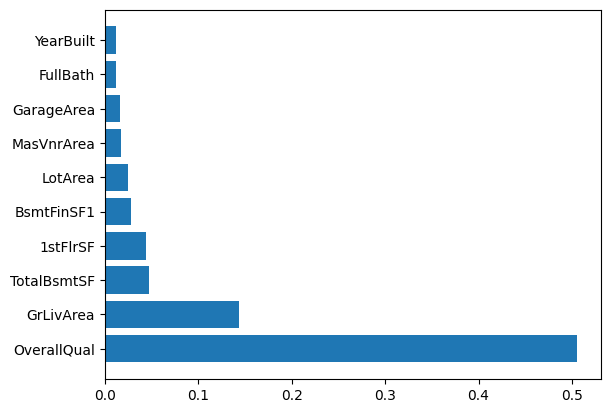

In [31]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

## Model Evaluation

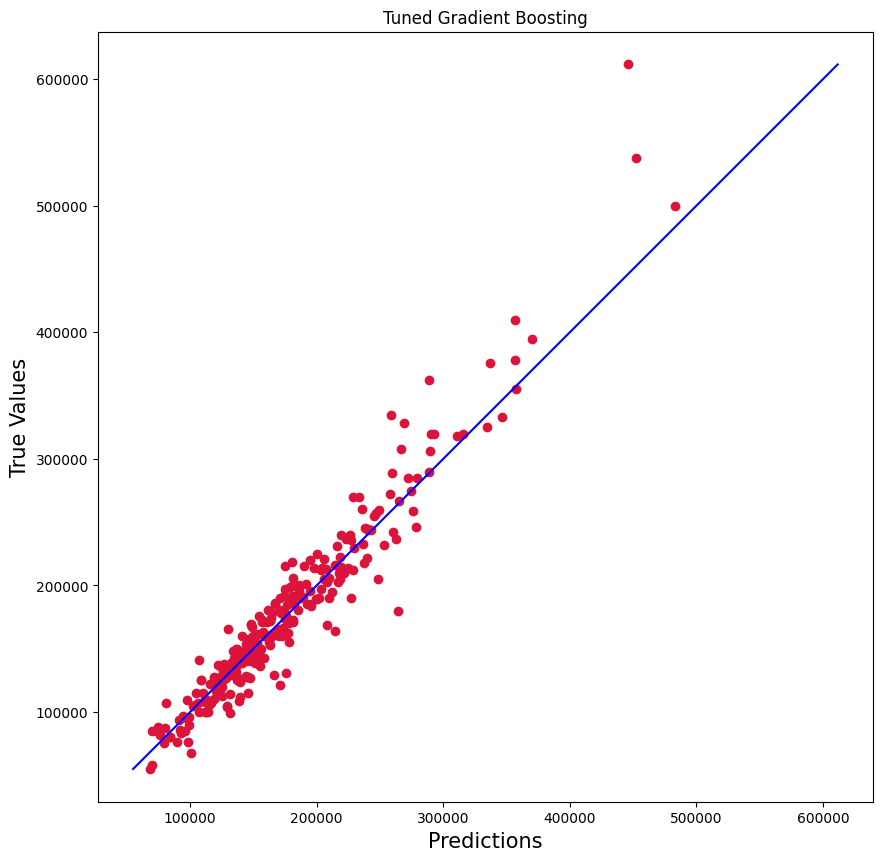

In [32]:
# Plot y_test vs y_test_pred

plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Gradient Boosting')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

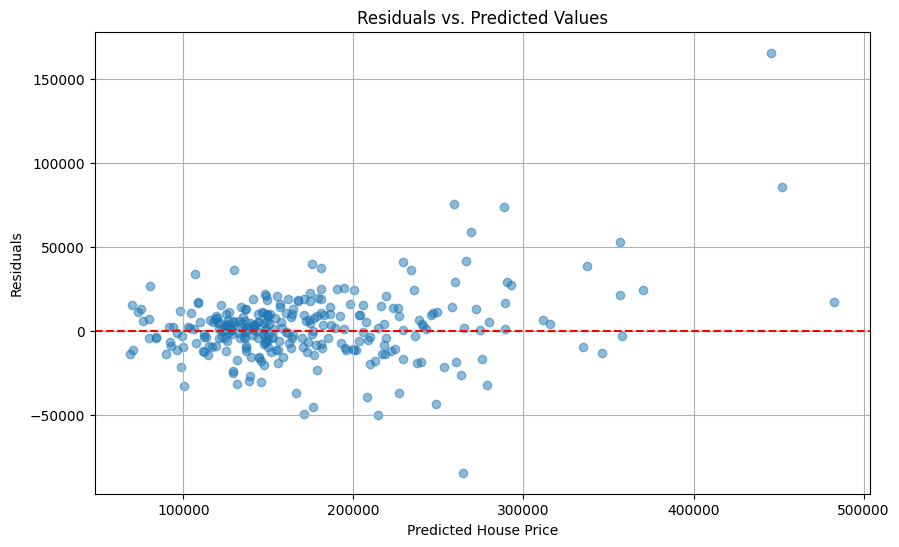

In [33]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [34]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 174699.6007
Standard Deviation: 74329.6605

Predicted Values (y_test_pred) statistics:
Mean: 172499.1446
Standard Deviation: 65416.6300


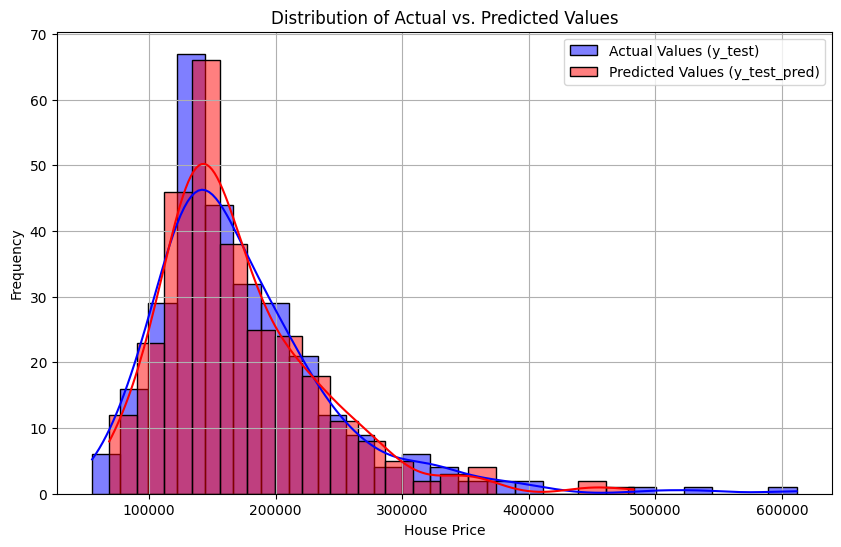

In [35]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
#sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

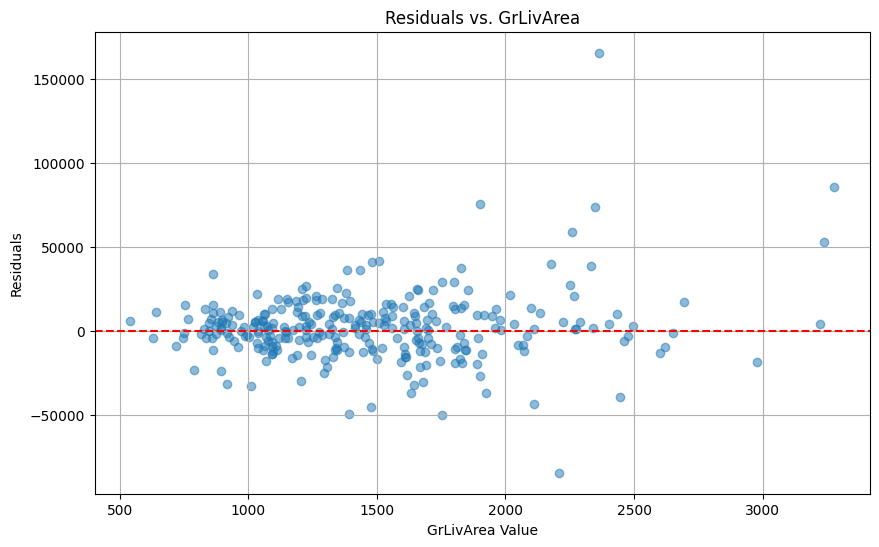

In [36]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

## Model Explainability

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [37]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [38]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_gbr_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_gbr_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                  feature  mean_abs_shap_gbr_5fk
3             OverallQual           23907.280467
0               GrLivArea           15412.237691
11            TotalBsmtSF            4017.195089
8              BsmtFinSF1            3909.964760
12               1stFlrSF            3901.731241
2                 LotArea            3437.460361
5               YearBuilt            2689.889218
4             OverallCond            2294.399214
41    KitchenQual_ordinal            2179.855304
17               FullBath            1948.194449
38    FireplaceQu_ordinal            1807.883876
45   BsmtFinType1_ordinal            1773.651794
25             GarageArea            1731.596752
50      house_age_derived            1479.579752
22             Fireplaces            1259.680962
26             WoodDeckSF            1163.480435
47      ExterQual_ordinal            1125.520573
6            YearRemodAdd            1105.103554
13               2ndFlrSF            1058.708635
7              MasVn

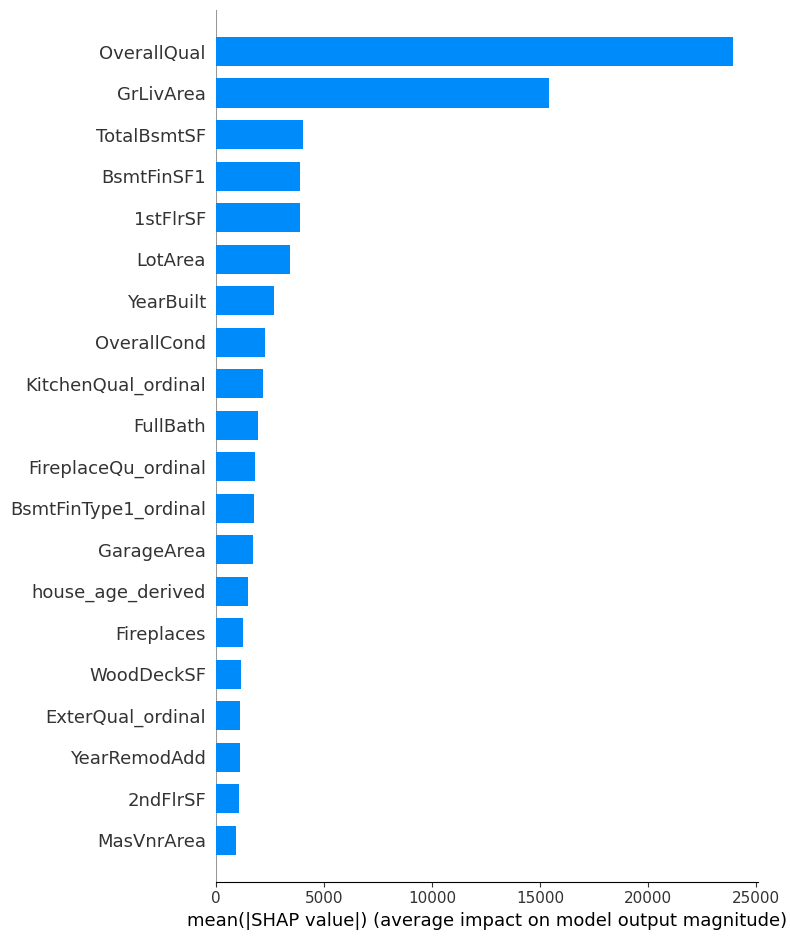

In [39]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

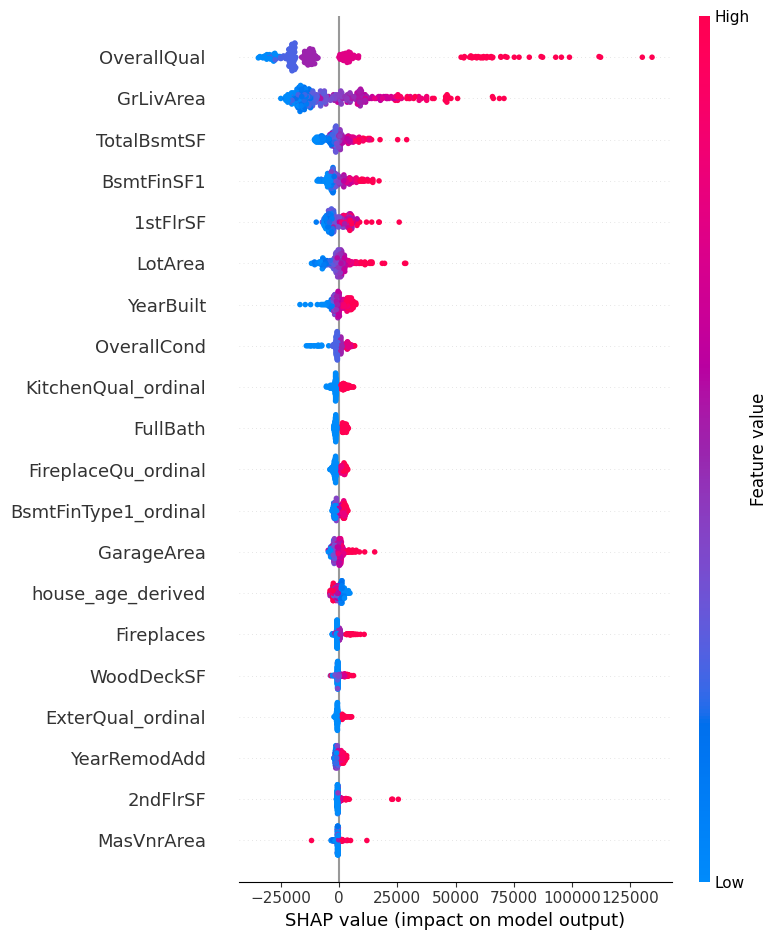

In [40]:
# summary violin plot
shap.summary_plot(shap_values, X_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

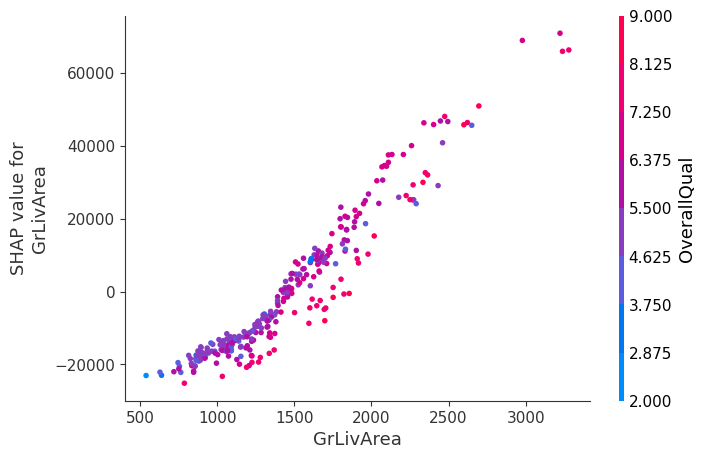

In [41]:
shap.dependence_plot('GrLivArea', shap_values, X_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

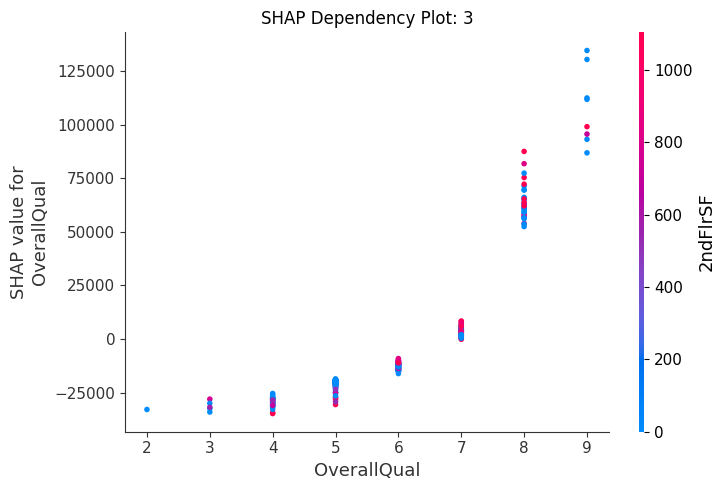

<Figure size 600x400 with 0 Axes>

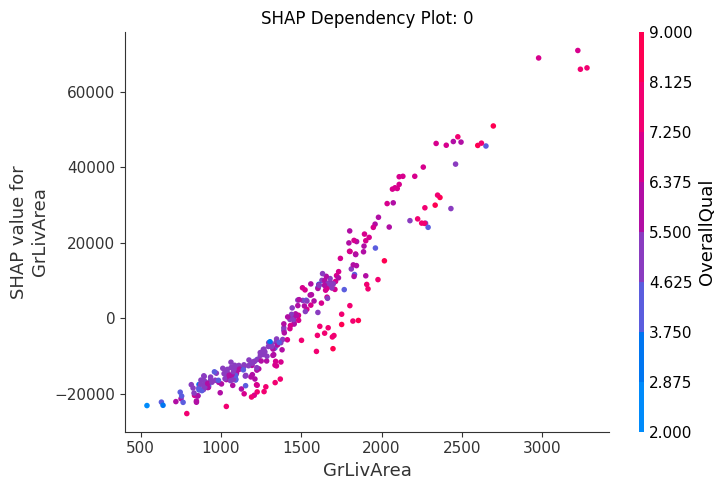

<Figure size 600x400 with 0 Axes>

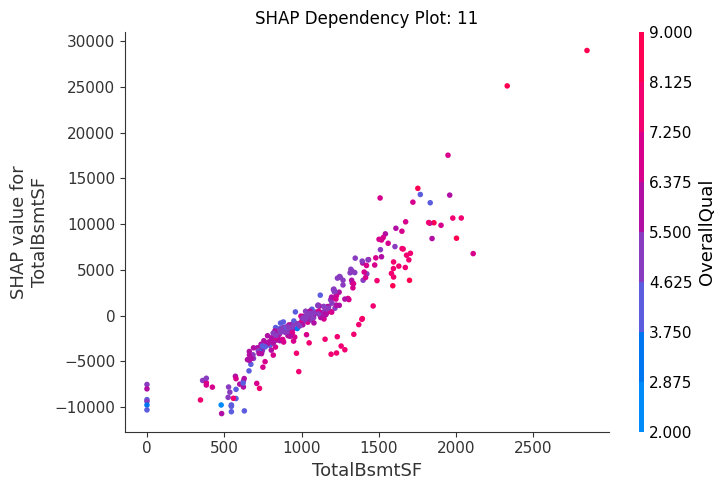

<Figure size 600x400 with 0 Axes>

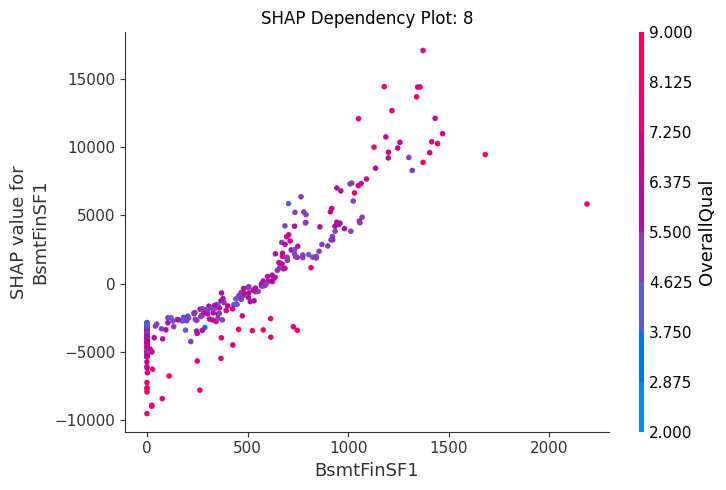

<Figure size 600x400 with 0 Axes>

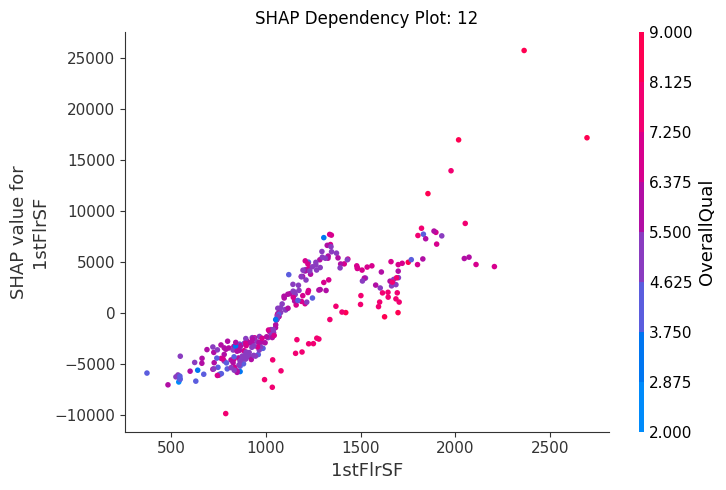

<Figure size 600x400 with 0 Axes>

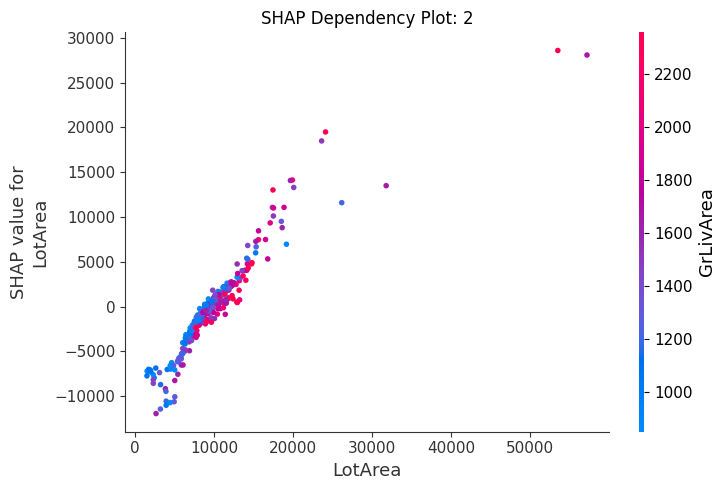

<Figure size 600x400 with 0 Axes>

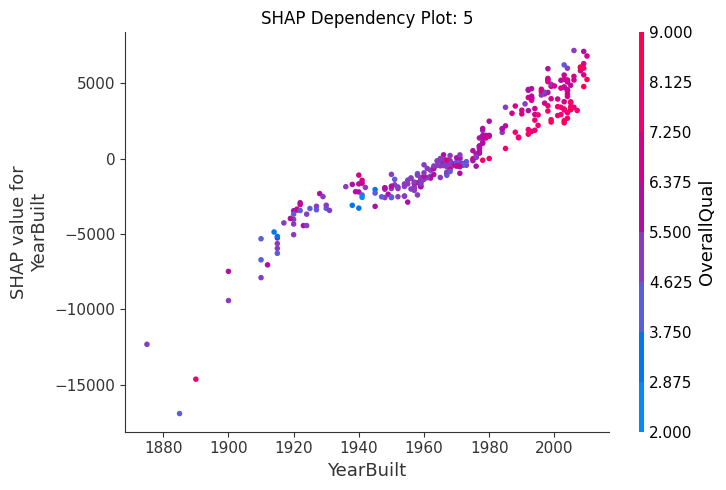

<Figure size 600x400 with 0 Axes>

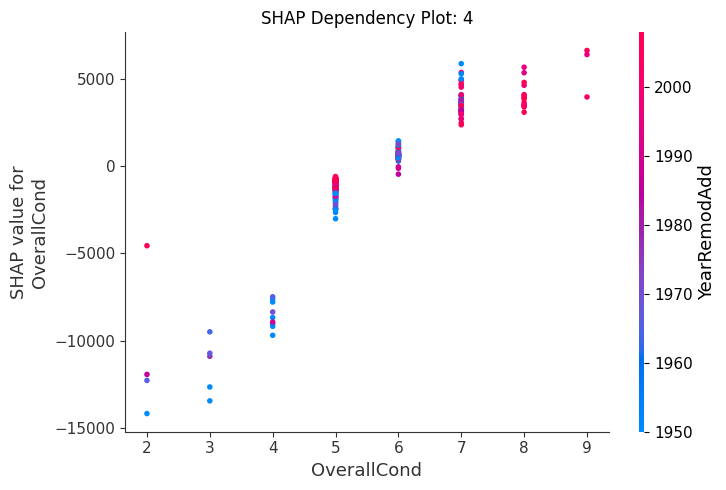

<Figure size 600x400 with 0 Axes>

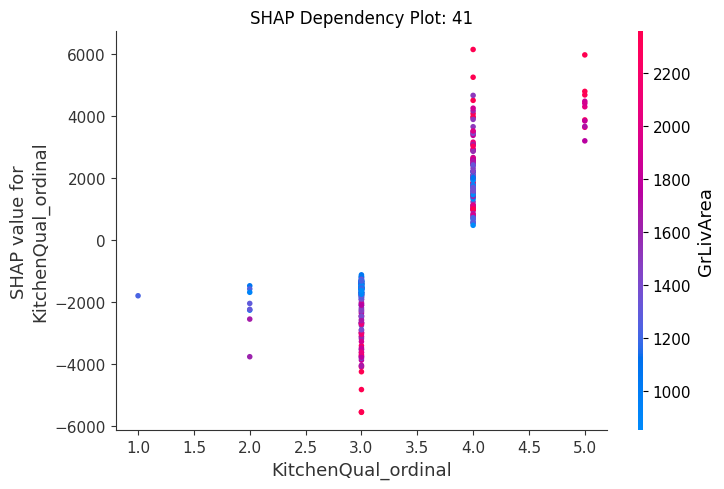

<Figure size 600x400 with 0 Axes>

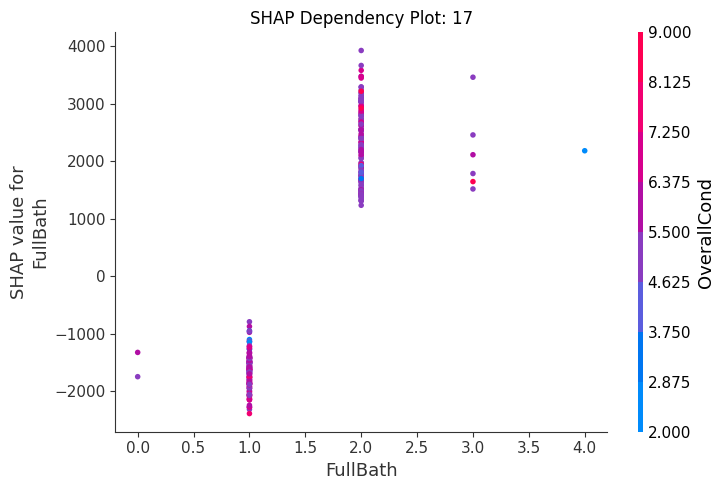

<Figure size 600x400 with 0 Axes>

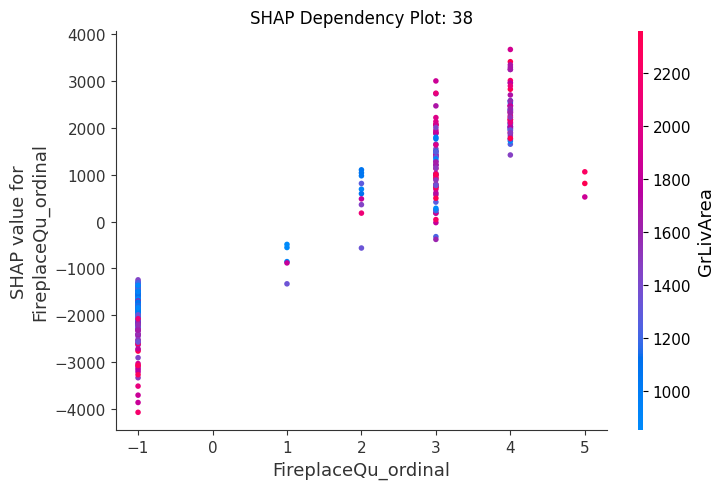

<Figure size 600x400 with 0 Axes>

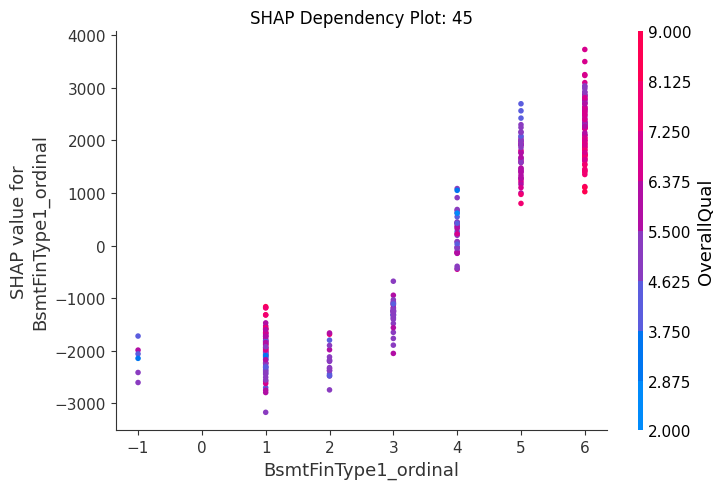

<Figure size 600x400 with 0 Axes>

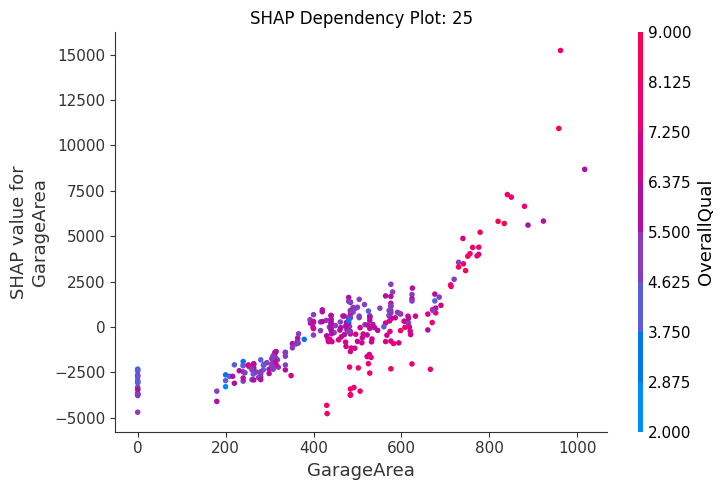

<Figure size 600x400 with 0 Axes>

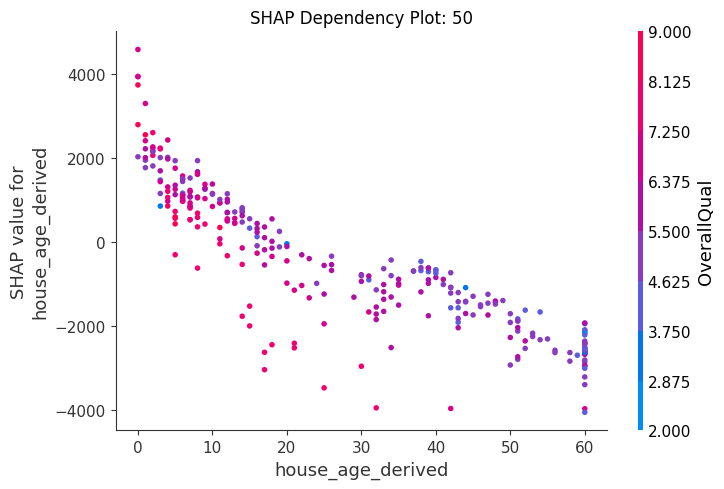

<Figure size 600x400 with 0 Axes>

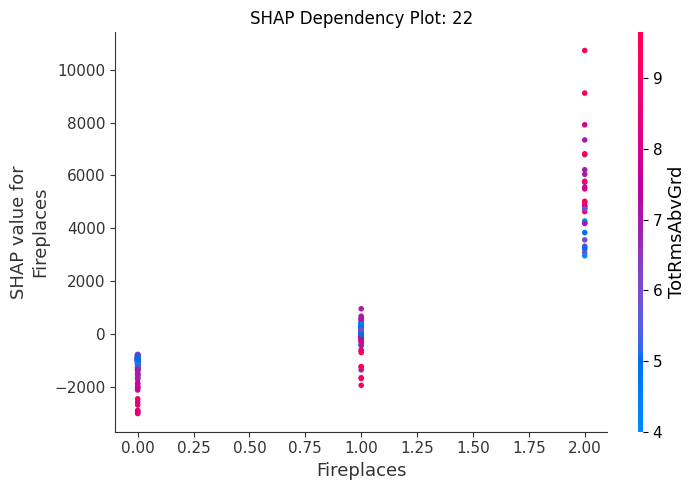

<Figure size 600x400 with 0 Axes>

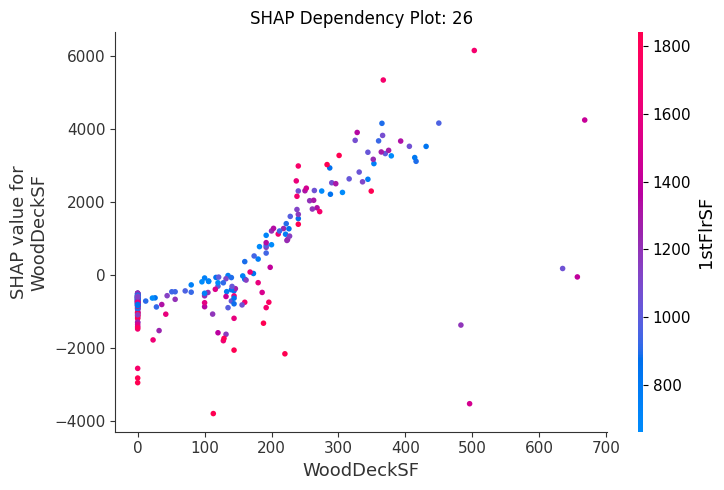

<Figure size 600x400 with 0 Axes>

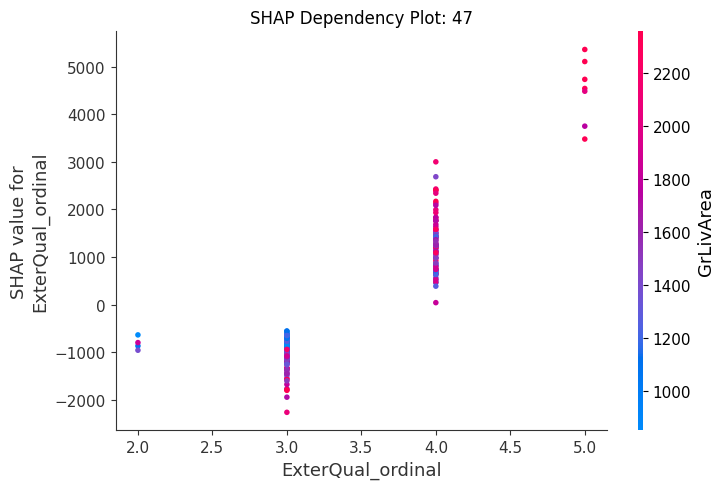

<Figure size 600x400 with 0 Axes>

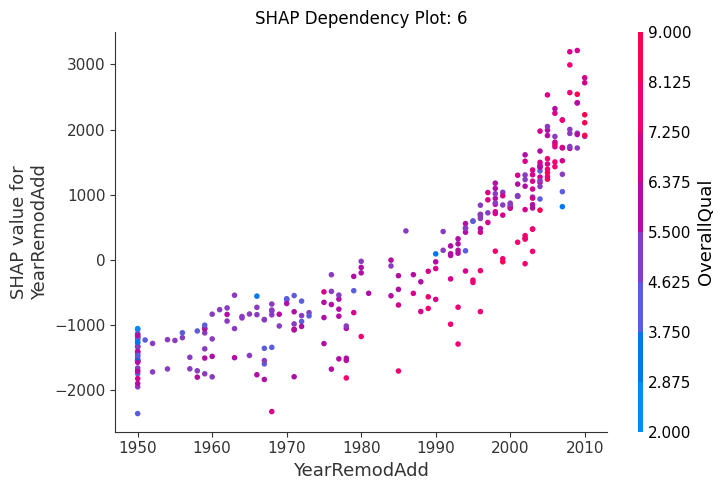

<Figure size 600x400 with 0 Axes>

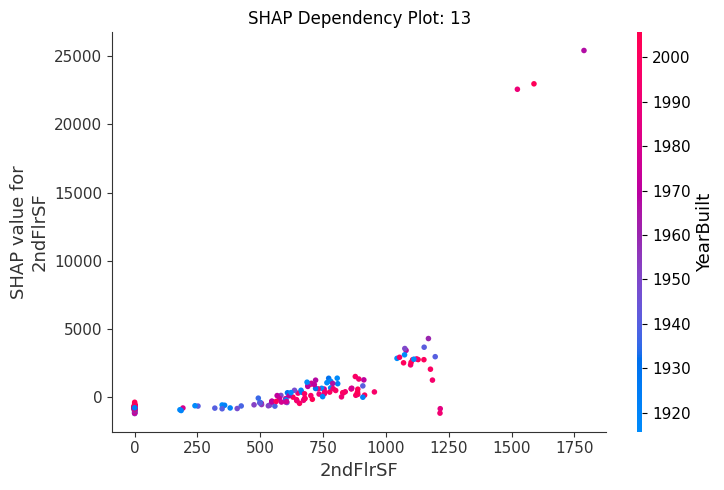

<Figure size 600x400 with 0 Axes>

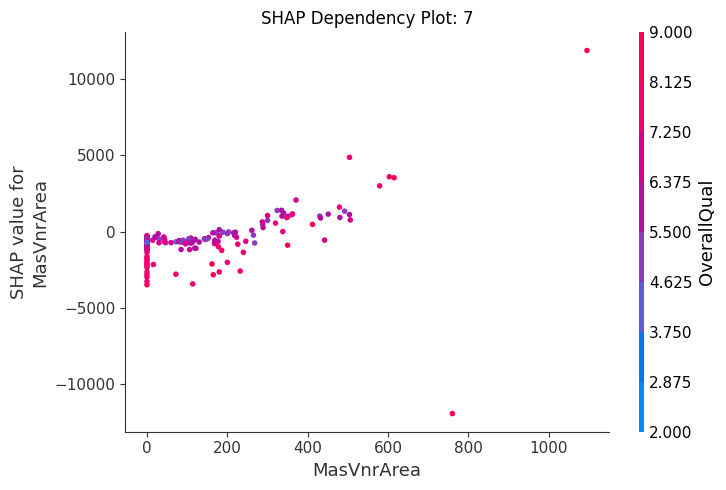

In [42]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

In [43]:
shap_importance_sorted

feature  mean_abs_shap_gbr_5fk
3                          OverallQual           23907.280467
0                            GrLivArea           15412.237691
11                         TotalBsmtSF            4017.195089
8                           BsmtFinSF1            3909.964760
12                            1stFlrSF            3901.731241
..                                 ...                    ...
158           exterior_covering_Stucco               0.000000
159   exterior_covering_Stucco_BrkFace               0.000000
160   exterior_covering_Stucco_CmentBd               0.000000
161   exterior_covering_Stucco_Plywood               0.000000
140  exterior_covering_HdBoard_Wd Shng               0.000000

[281 rows x 2 columns]

In [44]:
# export SHAP importance data into a csv
shap_importance_sorted.reset_index(inplace=True)
shap_importance_sorted.to_csv('shap_importance_gb.csv', index=False)

In [45]:
# Create a new DataFrame that includes the best value from the tuning process as well.
# This addresses the user's specific request.
full_comparison = pd.DataFrame({
    'model': ['GradientBoosting'] * 3,
    'metric': ['Test_R2', 'Best_Tuned_R2', 'Final_CV_mean_R2'],
    'score': [r2_5kf_test, study.best_value, cv_r2_mean]
})

In [46]:
full_comparison

model            metric     score
0  GradientBoosting           Test_R2  0.920973
1  GradientBoosting     Best_Tuned_R2  0.937326
2  GradientBoosting  Final_CV_mean_R2  0.910380

In [48]:
# export R2 scores into a csv
full_comparison.reset_index(inplace=True)
full_comparison.to_csv('r2_gb.csv', index=False)

### Extract the list of features and features that each one is most correlated with

In [ ]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = x_test.corr()

In [ ]:
most_correlated = {}

for feature in x_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [ ]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature_gbr_5fk']

In [ ]:
correlation_df

In [ ]:
# limit the above list to top 20 features ranked by mean abs SHAP values
rf_SHAP_feature_final = pd.merge(
    shap_importance_sorted, 
    correlation_df, 
    how='left',
    on = 'feature'
)

rf_SHAP_feature_final